## CASE STUDY 002

Aplicando SOM para análise do acumulado de flashes horário em cada estado brasileiro por estação

In [1]:
import sys; sys.path.insert(0, "/home/adriano/sthunder")
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sthunder import constants as const
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import shapely.geometry as sgeom
from descartes import PolygonPatch

import xarray as xr
from minisom import MiniSom

In [2]:
flashes_df = pd.read_csv("/glm/city_state.csv")
flashes_df.head()

city  uf  total             datetime           coords
0  Abel Figueiredo  PA      0  2020-01-01 00:00:00  POINT(-48.5 -5)
1  Abel Figueiredo  PA      0  2020-01-01 01:00:00  POINT(-48.5 -5)
2  Abel Figueiredo  PA      0  2020-01-01 02:00:00  POINT(-48.5 -5)
3  Abel Figueiredo  PA      0  2020-01-01 03:00:00  POINT(-48.5 -5)
4  Abel Figueiredo  PA      0  2020-01-01 04:00:00  POINT(-48.5 -5)

## Outono

In [3]:
flashes_df = flashes_df.groupby(
    ['uf', 'datetime']
).aggregate({'total': 'sum'}).reset_index()
flashes_df['datetime'] = pd.to_datetime(flashes_df['datetime'])
flashes_df = flashes_df.set_index('datetime', drop=True)
flashes_df['stations'] = -1
flashes_df.head()

uf  total  stations
datetime                                
2020-01-01 00:00:00  AC    263        -1
2020-01-01 01:00:00  AC     42        -1
2020-01-01 02:00:00  AC      0        -1
2020-01-01 03:00:00  AC      0        -1
2020-01-01 04:00:00  AC      0        -1

In [4]:
flashes_df.loc["2020-03-21" : "2020-06-20", ['stations']] = 0 # "autumn"
flashes_df.loc["2020-06-21" : "2020-09-22", ['stations']] = 1 # "winter"
flashes_df.loc["2020-09-23" : "2020-12-21", ['stations']] = 2 # "spring"
flashes_df.loc["2020-12-22" : "2021-01-01", ['stations']] = 3 # "summner"
flashes_df.loc["2020-01-01" : "2020-03-20", ['stations']] = 3 # "summner"
flashes_df.head()

uf  total  stations
datetime                                
2020-01-01 00:00:00  AC    263         3
2020-01-01 01:00:00  AC     42         3
2020-01-01 02:00:00  AC      0         3
2020-01-01 03:00:00  AC      0         3
2020-01-01 04:00:00  AC      0         3

In [5]:
pivot_table = flashes_df.reset_index().pivot(
     columns='uf', index='datetime', values='total'
).reset_index().set_index('datetime', drop=True)
pivot_table.head()

uf                    AC  AL   AM  AP   BA   CE  DF  ES    GO  MA  ...   PR  \
datetime                                                           ...        
2020-01-01 00:00:00  263   0   88   0  140   62   0   0  1969  79  ...  173   
2020-01-01 01:00:00   42   0  116   0   57  114   0   0   735  30  ...   66   
2020-01-01 02:00:00    0   0  119   0  294   77   0   0   161   3  ...   13   
2020-01-01 03:00:00    0   1   94   0   15   61   1   0   188   1  ...   17   
2020-01-01 04:00:00    0   0   85   0  218   42  25   0   168   0  ...    0   

uf                   RJ  RN  RO  RR   RS  SC  SE   SP   TO  
datetime                                                    
2020-01-01 00:00:00   0   8  27   0  210  92  48  148  132  
2020-01-01 01:00:00   0  20  38   0   31   0  80  321   19  
2020-01-01 02:00:00   0  31  47   0    8   5  13   58    2  
2020-01-01 03:00:00   0  22  32   0    1  80   0   66    0  
2020-01-01 04:00:00   0   1  38   0    0  37   0  139    9  

[5 rows x 27 columns]

In [6]:
data = pivot_table.values.T
nrow, ncol = 20, 20

SOM = MiniSom(x=nrow, y=ncol, input_len=data.shape[1], sigma=5,learning_rate=0.7, neighborhood_function='gaussian',
             topology='rectangular', activation_distance='euclidean', random_seed=42)
SOM.random_weights_init(data=data)
SOM.train_random(data=data, num_iteration=500)

In [13]:
print("%.2f" % SOM.topographic_error(data))

0.00


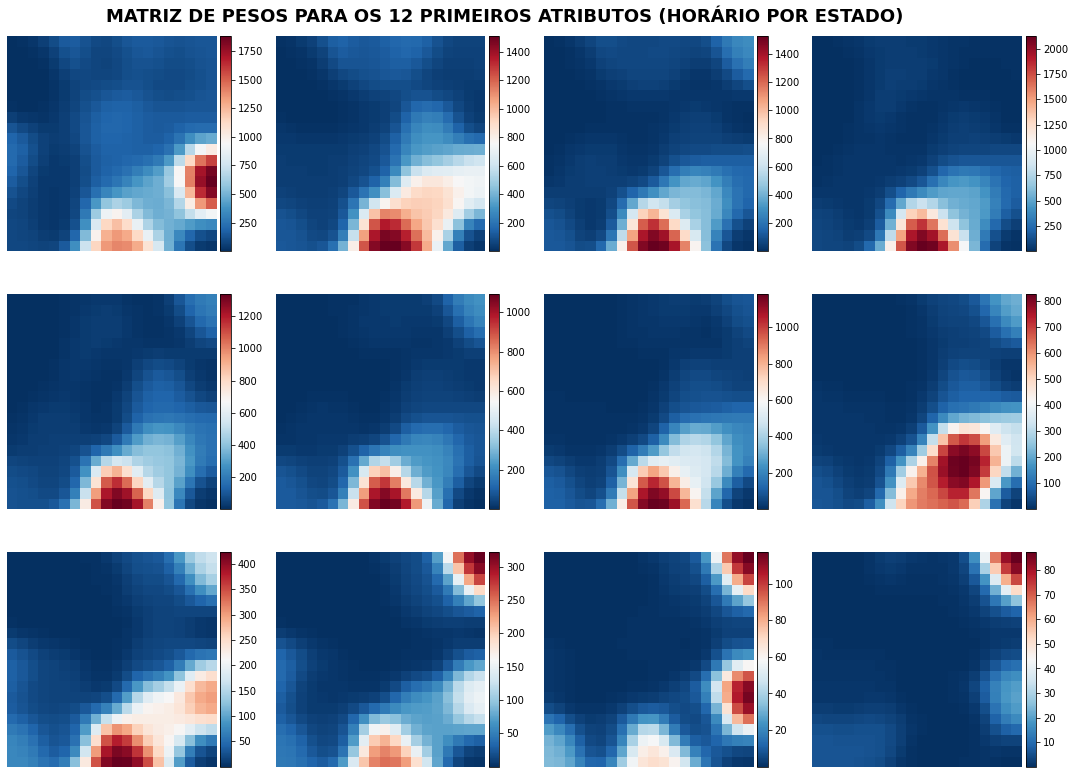

In [7]:
dpi = 100
width = np.round(1366 * 135 / 100)
height = 768*1.75
    
fig, ax = plt.subplots(3, 4, figsize=(width/dpi, height/dpi), facecolor = 'white')
fig.suptitle(f"MATRIZ DE PESOS PARA OS 12 PRIMEIROS ATRIBUTOS (HORÁRIO POR ESTADO)", 
             fontsize=18, fontweight='bold', y=0.91)

for i in range(12):
    row = i//4
    col = i%4
    
    divider = make_axes_locatable(ax[row][col])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    img = ax[row][col].pcolor(SOM._weights[:, :, i], cmap='RdBu_r')
    fig.colorbar(img, cax=cax, orientation='vertical')
    ax[row][col].axis('off')
    
plt.savefig(f"../weights_uf_hourly_nn_stations.png", 
                transparent=False, bbox_inches='tight', pad_inches=0.1)

In [207]:
pivot_table

uf                    AC  AL    AM   AP   BA   CE   DF  ES    GO    MA  ...  \
datetime                                                                ...   
2020-01-01 00:00:00  263   0    88    0  140   62    0   0  1969    79  ...   
2020-01-01 01:00:00   42   0   116    0   57  114    0   0   735    30  ...   
2020-01-01 02:00:00    0   0   119    0  294   77    0   0   161     3  ...   
2020-01-01 03:00:00    0   1    94    0   15   61    1   0   188     1  ...   
2020-01-01 04:00:00    0   0    85    0  218   42   25   0   168     0  ...   
...                  ...  ..   ...  ...  ...  ...  ...  ..   ...   ...  ...   
2020-12-31 19:00:00  572  69  3485  240   61    0  547   0  5560  9213  ...   
2020-12-31 20:00:00  697   0  4504  142    5    0  373   0  6924  9147  ...   
2020-12-31 21:00:00  581   0  3758  115    0    0    2   0  3540  9929  ...   
2020-12-31 22:00:00  642   0  1443   60    0    0    0   0   939  7979  ...   
2020-12-31 23:00:00  453   0   933   18    0    0    0   0  1601  3447  ...   

uf                    PR   RJ  RN   RO  RR   RS    SC  SE    SP    TO  
datetime                                                               
2020-01-01 00:00:00  173    0   8   27   0  210    92  48   148   132  
2020-01-01 01:00:00   66    0  20   38   0   31     0  80   321    19  
2020-01-01 02:00:00   13    0  31   47   0    8     5  13    58     2  
2020-01-01 03:00:00   17    0  22   32   0    1    80   0    66     0  
2020-01-01 04:00:00    0    0   1   38   0    0    37   0   139     9  
...                  ...  ...  ..  ...  ..  ...   ...  ..   ...   ...  
2020-12-31 19:00:00  833  977   0  353   4   57   277   0  1777  9146  
2020-12-31 20:00:00  621   92   0   72   1   70   459   0  1553  7701  
2020-12-31 21:00:00  273  335   0   43   2   20   502   0  1014  4415  
2020-12-31 22:00:00   60  234   0   44   0    2  1472   0  1174  1942  
2020-12-31 23:00:00    9  148   0  135   0    0  2290   0   784   180  

[8784 rows x 27 columns]

In [8]:
temp = flashes_df.reset_index()
temp

datetime  uf  total  stations
0      2020-01-01 00:00:00  AC    263         3
1      2020-01-01 01:00:00  AC     42         3
2      2020-01-01 02:00:00  AC      0         3
3      2020-01-01 03:00:00  AC      0         3
4      2020-01-01 04:00:00  AC      0         3
...                    ...  ..    ...       ...
237163 2020-12-31 19:00:00  TO   9146         3
237164 2020-12-31 20:00:00  TO   7701         3
237165 2020-12-31 21:00:00  TO   4415         3
237166 2020-12-31 22:00:00  TO   1942         3
237167 2020-12-31 23:00:00  TO    180         3

[237168 rows x 4 columns]

(0.0, 20.0)

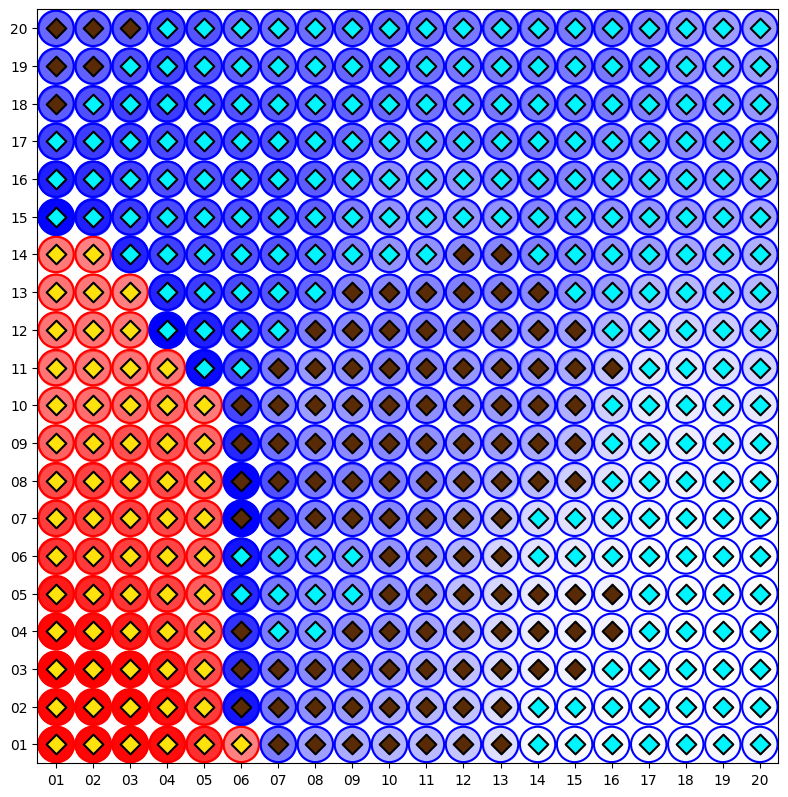

In [10]:
color_map = np.full((*SOM._weights.shape[:-1],), 'white')
alpha_map = np.full((*SOM._weights.shape[:-1],), 0.)
stations_map = np.full((*SOM._weights.shape[:-1],), 0)

P90 = np.percentile(data.ravel(), 90)
THR = 0.25
markersize = 1000
linewidth = 1.5
# colors = ['#c9a76a', '#246d8c', '#ffe20c 8fab3a', '#f2592b']
colors = ['#592a06', '#00f6ff', '#ffe20c', '#f2592b']

for i in np.arange(SOM._weights.shape[0]):
    for j in np.arange(SOM._weights.shape[1]):
        w = SOM._weights[i, j, :]
        
        act = w[w>=P90].shape[0]
        ina = w[w<P90].shape[0]
        
        if act/(act+ina) >= THR:
            aux = temp.loc[np.where(w>=P90)[0]].groupby('stations').agg({'stations': 'count'})
            maxv = None
            maxs = None
            for s, row  in aux.iterrows():
                if maxv == None:
                    maxv = row['stations']
                    maxs = s
                else:
                    if row['stations'] > maxv:
                        maxv = row['stations']
                        maxs = s
            stations_map[i][j] = maxs
            color_map[i][j] = 'red'
            alpha_map[i][j] = act/(act+ina)
        else:
            aux = temp.loc[np.where(w<P90)[0]].groupby('stations').agg({'stations': 'count'})
            maxv = None
            maxs = None
            for s, row  in aux.iterrows():
                if maxv == None:
                    maxv = row['stations']
                    maxs = s
                else:
                    if row['stations'] > maxv:
                        maxv = row['stations']
                        maxs = s
            stations_map[i][j] = maxs
            color_map[i][j] = 'red'
            alpha_map[i][j] = act/(act+ina)
            
            color_map[i][j] = 'blue'
            alpha_map[i][j] = act/(act+ina)
            
xb, yb = np.where(color_map == 'blue')
xr, yr = np.where(color_map == 'red')

alpha_map[xb, yb] = alpha_map[xb, yb]/alpha_map[xb, yb].max()
alpha_map[xr, yr] = alpha_map[xr, yr]/alpha_map[xr, yr].max()


dpi = 100
width = np.round(1366 * 70 / 100)
height = 768*1.3
facecolor = 'white'

fig, ax = plt.subplots(figsize=(width/dpi, height/dpi), 
                       dpi=dpi, facecolor=facecolor)

for i in range(color_map.shape[0]):
    for j in range(color_map.shape[1]):
        ax.scatter([i+.5], [j+.5], color=color_map[i][j], marker='o', s=650, alpha=alpha_map[i][j], 
                lw=1.5, ec=color_map[i][j], zorder=1)
        ax.scatter([i+.5], [j+.5], color='none', marker='o', s=650,
                lw=1.5, ec=color_map[i][j], zorder=2)
        ax.scatter([i+.5], [j+.5], color=colors[stations_map[i][j]], marker='D', s=100,
                ec='k', lw=1.5, zorder=2, alpha=1)
       
ax.set_xticks(np.arange(nrow)+0.5)
ax.set_xticklabels([str(v).zfill(2) for v in np.arange(nrow)+1])
ax.set_yticks(np.arange(ncol)+0.5)
ax.set_yticklabels([str(v).zfill(2) for v in np.arange(ncol)+1])
ax.set_xlim([0, color_map.shape[0]])
ax.set_ylim([0, color_map.shape[1]])

In [220]:
np.unique(stations_map.ravel())

array([0, 1, 2])

15.0
51.0
138.0
327.0
765.0
916.0
1098.0
1326.0
1620.9799999999814
2003.0
3337.9899999999907
7265.659999999974


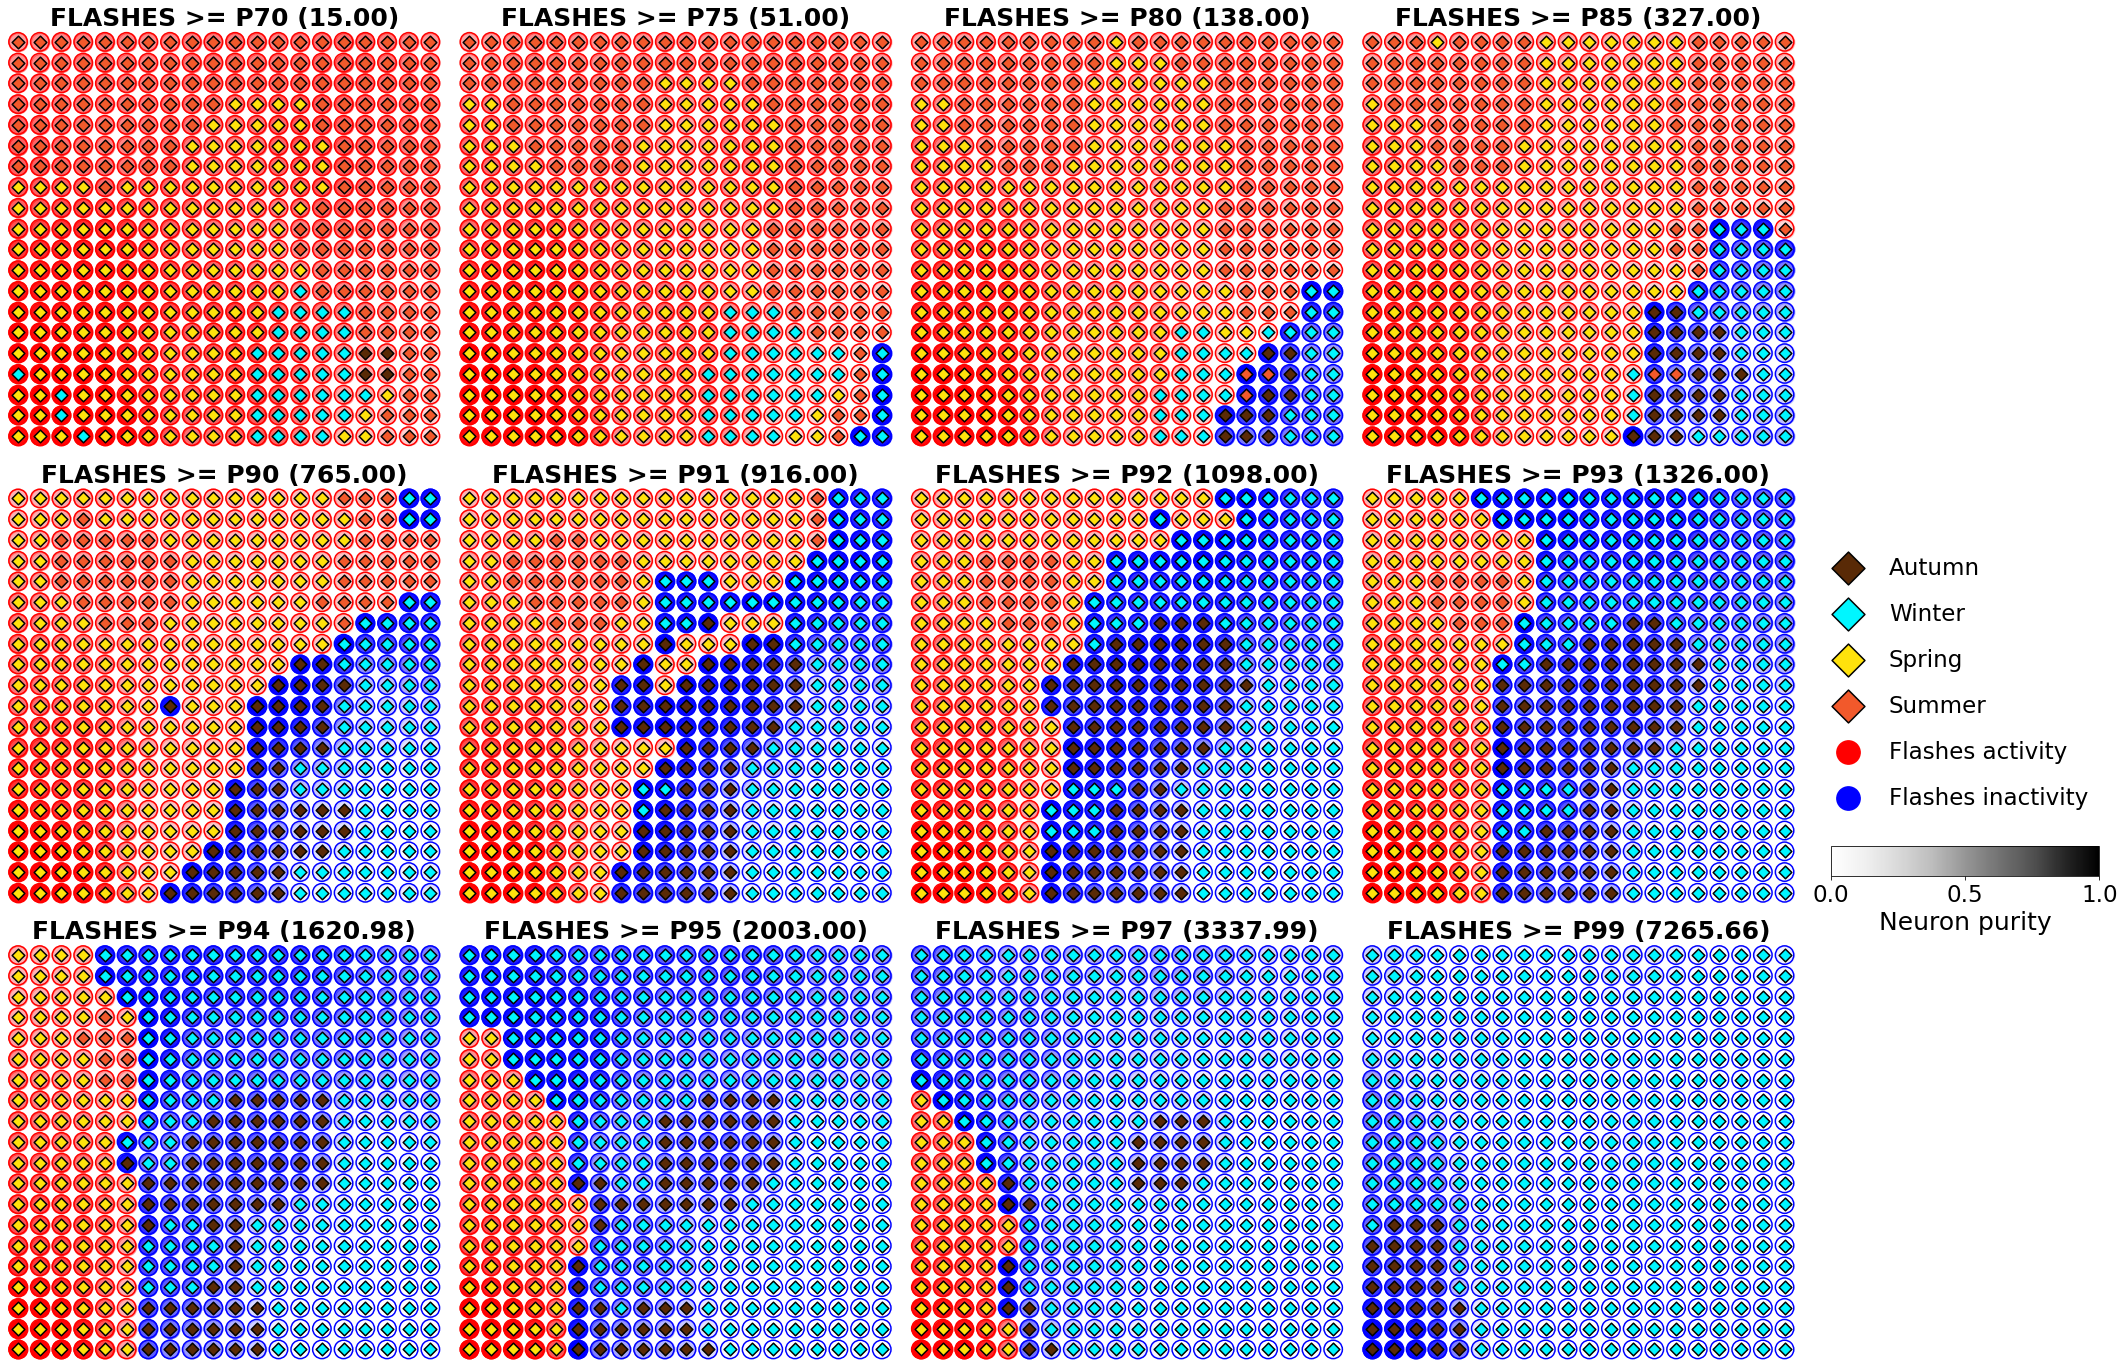

In [53]:
dpi = 110
width = np.round(1366 * 200 / 100)
height = 768*3.5
    
fig, ax = plt.subplots(3, 4, figsize=(width/dpi, height/dpi), facecolor = 'white')

PS = [
    70, 75, 80, 85, 90, 91, 92, 93, 94, 95, 97, 99
]
PCT = [np.percentile(data.ravel(), pn) for pn in PS]

titles = [f"FLASHES >= P{pn} ({PCT[i]:.2f})" for i, pn in enumerate(PS)]

for x in range(12):
    row = x//4
    col = x%4
    
    color_map = np.full((*SOM._weights.shape[:-1],), 'white')
    alpha_map = np.full((*SOM._weights.shape[:-1],), 0.)
    stations_map = np.full((*SOM._weights.shape[:-1],), 0)
    
    P90 = PCT[x]
    print(P90)
    THR = 0.10
    markersize = 1000
    linewidth = 1.5

    for i in np.arange(SOM._weights.shape[0]):
        for j in np.arange(SOM._weights.shape[1]):
            w = SOM._weights[i, j, :]
            act = w[w>=P90].shape[0]
            ina = w[w<P90].shape[0]

            if act/(act+ina) >= THR:
                aux = temp.loc[np.where(w>=P90)[0]].groupby('stations').agg({'stations': 'count'})
                maxv = None
                maxs = None
                for s, r  in aux.iterrows():
                    if maxv == None:
                        maxv = r['stations']
                        maxs = s
                    else:
                        if r['stations'] > maxv:
                            maxv = r['stations']
                            maxs = s
                stations_map[i][j] = maxs
                color_map[i][j] = 'red'
                alpha_map[i][j] = act/(act+ina)
            else:
                aux = temp.loc[np.where(w<P90)[0]].groupby('stations').agg({'stations': 'count'})
                maxv = None
                maxs = None
                for s, r  in aux.iterrows():
                    if maxv == None:
                        maxv = r['stations']
                        maxs = s
                    else:
                        if r['stations'] > maxv:
                            maxv = r['stations']
                            maxs = s
                stations_map[i][j] = maxs
                color_map[i][j] = 'red'
                alpha_map[i][j] = act/(act+ina)

                color_map[i][j] = 'blue'
                alpha_map[i][j] = act/(act+ina)

    xb, yb = np.where(color_map == 'blue')
    xr, yr = np.where(color_map == 'red')
    
    if len(xb) > 0:
        alpha_map[xb, yb] = alpha_map[xb, yb]/alpha_map[xb, yb].max()
    if len(xr) > 0:
        alpha_map[xr, yr] = alpha_map[xr, yr]/alpha_map[xr, yr].max()

    for i in range(color_map.shape[0]):
        for j in range(color_map.shape[1]):
            ax[row][col].scatter([i+.5], [j+.5], color=color_map[i][j], marker='o', s=340, alpha=alpha_map[i][j], 
                    lw=1.5, ec=color_map[i][j], zorder=1)
            ax[row][col].scatter([i+.5], [j+.5], color='none', marker='o', s=340,
                    lw=1.5, ec=color_map[i][j], zorder=2)
            ax[row][col].scatter([i+.5], [j+.5], color=colors[stations_map[i][j]], marker='D', s=80,
                ec='k', lw=1.5, zorder=2, alpha=1)

#     ax[row][col].set_xticks(np.arange(nrow)+0.5)
#     ax[row][col].set_xticklabels([str(v).zfill(2) for v in np.arange(nrow)+1])
#     ax[row][col].set_yticks(np.arange(ncol)+0.5)
#     ax[row][col].set_yticklabels([str(v).zfill(2) for v in np.arange(ncol)+1])
    ax[row][col].set_title(titles[x], fontdict={'size': 25, 'weight': 'bold'})
    ax[row][col].axis('off')
    
    ax[row][col].set_xlim([0, color_map.shape[0]])
    ax[row][col].set_ylim([0, color_map.shape[1]])
#     break
    

cax = fig.add_axes([1.08, 0.26, 0.02, 0.5])
cax.scatter([], [], color=colors[0], s=540, marker='D', lw=1.5, ec='k', label='Autumn')
cax.scatter([], [], color=colors[1], s=540, marker='D', lw=1.5, ec='k', label='Winter')
cax.scatter([], [], color=colors[2], s=540, marker='D', lw=1.5, ec='k', label='Spring')
cax.scatter([], [], color=colors[3], s=540, marker='D', lw=1.5, ec='k', label='Summer')
cax.scatter([], [], color='red', s=540, marker='o', lw=1.5, ec='red', label='Flashes activity')
cax.scatter([], [], color='blue', s=540, marker='o', lw=1.5, ec='blue', label='Flashes inactivity')
# mx, my = np.meshgrid(np.linspace(0, 1, 20), np.linspace(0, 1, 20))
cax.legend(loc='center', ncol=1, labelspacing=1, fontsize=23, frameon=False)
cax.axis('off')

cax2 = fig.add_axes([1.02, 0.40, 0.15, 0.017])
img = cax2.pcolor([[]], cmap='Greys', vmin=0, vmax=1)
cbar = fig.colorbar(img, cax=cax2, orientation='horizontal')
cbar.ax.tick_params(labelsize=23)
cbar.ax.set_xlabel('Neuron purity', rotation=0, fontsize=25, fontweight='500')
# cbar.ax.get_xaxis().labelpad = -80
# cbar.ax.tick_params(labelsize=15)



plt.subplots_adjust(left=0, bottom=None, right=1, top=None,
                        hspace=0.10, wspace=0.04)

plt.savefig(f"../neurons_percentile_variation_stations.png", dpi=dpi,
                transparent=False, bbox_inches='tight', pad_inches=0.1)

plt.savefig(f"../neurons_percentile_variation_stations_cs02.pdf", dpi=dpi,
                transparent=False, bbox_inches='tight', pad_inches=0.1)

In [369]:
color_map = np.full((*SOM._weights.shape[:-1],), 'white')
alpha_map = np.full((*SOM._weights.shape[:-1],), 0.)

P90 = np.percentile(data.ravel(), 90)
THR = 0.10
markersize = 1000
linewidth = 1.5

for i in np.arange(SOM._weights.shape[0]):
    for j in np.arange(SOM._weights.shape[1]):
        w = SOM._weights[i, j, :]
        act = w[w>=P90].shape[0]
        ina = w[w<P90].shape[0]

        if act/(act+ina) >= THR:
            color_map[i][j] = 'red'
            alpha_map[i][j] = act/(act+ina)
        else:
            color_map[i][j] = 'blue'
            alpha_map[i][j] = act/(act+ina)

xb, yb = np.where(color_map == 'blue')
xr, yr = np.where(color_map == 'red')

if len(xb) > 0:
    alpha_map[xb, yb] = alpha_map[xb, yb]/alpha_map[xb, yb].max()
if len(xr) > 0:
    alpha_map[xr, yr] = alpha_map[xr, yr]/alpha_map[xr, yr].max()

In [370]:
ngdf = gpd.read_file(
    const.SHP_BRAZIL_STATES
).set_index('sigla').loc[pivot_table.columns][['geometry']]

ngdf.head()

geometry
uf                                                   
AC  POLYGON ((-73.60818 -7.20194, -72.86963 -7.528...
AL  POLYGON ((-35.46516 -8.82549, -35.46626 -8.827...
AM  POLYGON ((-67.32553 2.03012, -67.32234 2.01741...
AP  POLYGON ((-51.18168 4.00889, -51.17900 3.99812...
BA  POLYGON ((-39.28820 -8.56290, -39.28229 -8.567...

In [371]:
def plot_state_map_original():
    ngdf = gpd.read_file(
        const.SHP_BRAZIL_STATES
    ).set_index('sigla').loc[pivot_table.columns][['geometry']]

    ngdf.head()
    c, a = [], []
    for i, (state, row) in enumerate(ngdf.iterrows()):
        winner = SOM.winner(pivot_table[[state]].values.T[0])

        c.append(color_map[winner[0]][winner[1]])
        a.append(alpha_map[winner[0]][winner[1]])

    ngdf['color'] = c
    ngdf['alpha'] = a

    dpi = 100
    width = np.round(1366 * 70 / 100)
    height = 768*1.1
    facecolor = 'white'

#     fig, ax = plt.subplots(figsize=(width/dpi, height/dpi), 
#                            dpi=dpi, facecolor=facecolor)

#     ax.set_title(const.TITLE_SINGLE_DENSITY_CITY_MAP, 
#                  fontdict=const.STYLE_TITLE)
#     ax.grid(ls='--', alpha=0.5)
#     ax.set_xlabel("Longitude [°]")
#     ax.set_ylabel("Latitude [°]")

#     ngdf[ngdf['color'] == 'red'].plot(cmap='Reds', ec='k', lw=0.1, 
#                                       column='alpha', ax=ax)
#     ngdf[ngdf['color'] == 'blue'].plot(cmap='Blues', ec='k', lw=0.1, 
#                                        column='alpha', ax=ax)

#     plt.savefig(f"../single_density_state_map.png", 
#                 transparent=False, bbox_inches='tight', pad_inches=0.1)
    return ngdf

In [372]:
def plot_state_map_prob():
    ngdf = gpd.read_file(
        const.SHP_BRAZIL_STATES
    ).set_index('sigla').loc[pivot_table.columns][['geometry']]

    ngdf.head()
    np.random.seed(42)
    c, a, mh = [], [], []
    for i, (state, row) in enumerate(ngdf.iterrows()):
        x, y = SOM.winner(pivot_table[[state]].values.T[0])

        if color_map[x][y] == 'blue':
            sc = prob = np.random.choice(['blue', 'red'], 1, p=[alpha_map[x][y], 1-alpha_map[x][y]])[0]
            if sc == 'blue':
    #             print(state, "blue -> blue", alpha_map[x][y], 1-alpha_map[x][y])
                sa = alpha_map[x][y]
                mh.append(1)
            else:
    #             print(state, "blue -> red", alpha_map[x][y], 1-alpha_map[x][y])
                sa = 1-alpha_map[x][y]
                mh.append(0)
        else:
            sc = prob = np.random.choice(['red', 'blue'], 1, p=[alpha_map[x][y], 1-alpha_map[x][y]])[0]
            if sc == 'red':
                mh.append(1)
    #             print(state, "red -> red", alpha_map[x][y], 1-alpha_map[x][y])
                sa = alpha_map[x][y]
            else :
    #             print(state, "red -> blue", alpha_map[x][y], 1-alpha_map[x][y])
                sa = 1-alpha_map[x][y]
                mh.append(0)

        c.append(sc)
        a.append(sa)

    ngdf['color'] = c
    ngdf['alpha'] = a
    ngdf['misshit'] = mh

    dpi = 100
    width = np.round(1366 * 70 / 100)
    height = 768*1.1
    facecolor = 'white'

#     fig, ax = plt.subplots(figsize=(width/dpi, height/dpi), 
#                            dpi=dpi, facecolor=facecolor)

#     ax.set_title(const.TITLE_SINGLE_DENSITY_CITY_MAP, 
#                  fontdict=const.STYLE_TITLE)
#     ax.grid(ls='--', alpha=0.5)
#     ax.set_xlabel("Longitude [°]")
#     ax.set_ylabel("Latitude [°]")

#     ngdf[ngdf['color'] == 'red'].plot(cmap='Reds', ec='k', lw=0.1, 
#                                       column='alpha', ax=ax)
#     ngdf[ngdf['color'] == 'blue'].plot(cmap='Blues', ec='k', lw=0.1, 
#                                        column='alpha', ax=ax)

#     plt.savefig(f"../single_density_state_map_prob.png", 
#                 transparent=False, bbox_inches='tight', pad_inches=0.1)
    return ngdf

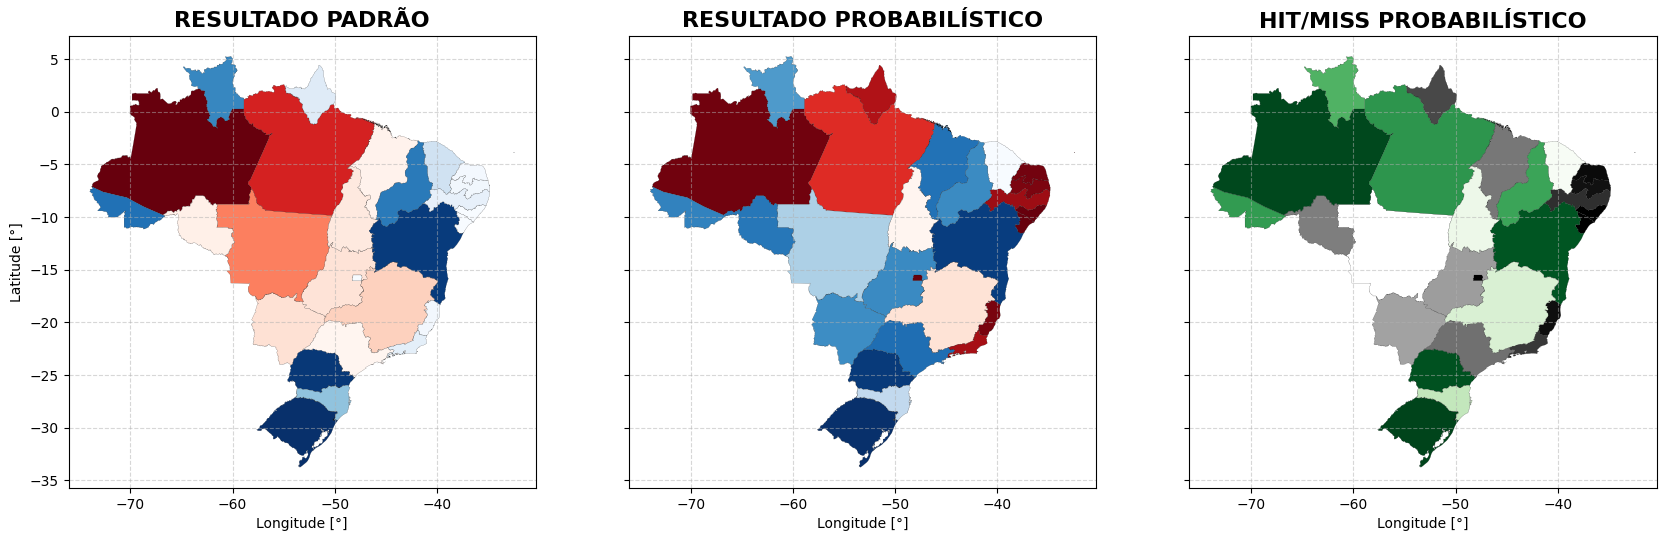

In [373]:
dpi = 100
width = np.round(1366 * 150 / 100)
height = 768*1.75

fig, ax = plt.subplots(1, 3, figsize=(width/dpi, height/dpi), 
                       dpi=dpi, facecolor='w', sharex=True, sharey=True)

orig_map = plot_state_map_original()
prob_map = plot_state_map_prob()

ax[0].set_title('RESULTADO PADRÃO', fontdict=const.STYLE_TITLE)
ax[0].grid(ls='--', alpha=0.5)
ax[0].set_xlabel("Longitude [°]")
ax[0].set_ylabel("Latitude [°]")

orig_map[orig_map['color'] == 'red'].plot(cmap='Reds', ec='k', lw=0.1, 
                                  column='alpha', ax=ax[0])
orig_map[orig_map['color'] == 'blue'].plot(cmap='Blues', ec='k', lw=0.1, 
                                   column='alpha', ax=ax[0])


ax[1].set_title('RESULTADO PROBABILÍSTICO', fontdict=const.STYLE_TITLE)
ax[1].grid(ls='--', alpha=0.5)
ax[1].set_xlabel("Longitude [°]")
# ax[1].set_ylabel("Latitude [°]")

prob_map[prob_map['color'] == 'red'].plot(cmap='Reds', ec='k', lw=0.1, 
                                  column='alpha', ax=ax[1])
prob_map[prob_map['color'] == 'blue'].plot(cmap='Blues', ec='k', lw=0.1, 
                                   column='alpha', ax=ax[1])


ax[2].set_title('HIT/MISS PROBABILÍSTICO', fontdict=const.STYLE_TITLE)
ax[2].grid(ls='--', alpha=0.5)
ax[2].set_xlabel("Longitude [°]")
# ax[2].set_ylabel("Latitude [°]")

prob_map[prob_map['misshit'] == 0].plot(cmap='Greys', ec='k', lw=0.1, 
                                  column='alpha', ax=ax[2])
prob_map[prob_map['misshit'] == 1].plot(cmap='Greens', ec='k', lw=0.1, 
                                   column='alpha', ax=ax[2])

plt.savefig(f"../summary_maps_hourly_uf.png", 
                transparent=False, bbox_inches='tight', pad_inches=0.1)

In [374]:
blue_blue = prob_map.query("color == 'blue' and misshit == 1").count()[0]
blue_red = prob_map.query("color == 'blue' and misshit == 0").count()[0]

red_red = prob_map.query("color == 'red' and misshit == 1").count()[0]
red_blue = prob_map.query("color == 'red' and misshit == 0").count()[0]

sources = [0, 0, 1, 1]
targets = [1+2, 0+2, 0+2, 1+2]
values = [blue_blue, blue_red, red_blue, red_red]
labels = [
    'Inatividade', 'Atividade', 'Miss', 'Hit',
]


colors_node = ['darkblue', 'darkred', '#303030', '#0e532b']
colors_link = ['rgba(43, 101, 227, 0.7)', 'rgba(43, 212, 227, 0.7)', 
               'rgba(231, 120, 110, 0.7)', 'rgba(255, 21, 0, 0.7)']

link = dict(source=sources, target=targets, value=values, color=colors_link)
node = dict(color=colors_node, pad=30, thickness=50)

sankey = go.Sankey(link=link, node=node)
fig = go.Figure(sankey)
fig.update_layout(
    title={
        'text': "<b>ANÁLISE DA INCERTEZA DO CLASSIFICAÇÃO<b>",   
        'y': 0.94,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
            family="Arial",
            size=24,
            color="black",
        )
    },
    font=dict(
        family="Arial",
        size=17,
        color="black",
    )
)

dpi=500
width = 3.5*dpi
height = 1.75*dpi
# fig.write_image("../classes.png", width=1366, height=758, scale=1)
pio.write_image(fig, "../sankey_prob_uf_hourly.svg", width=width, height=height, scale=1)
fig.show()

In [ ]:
rd

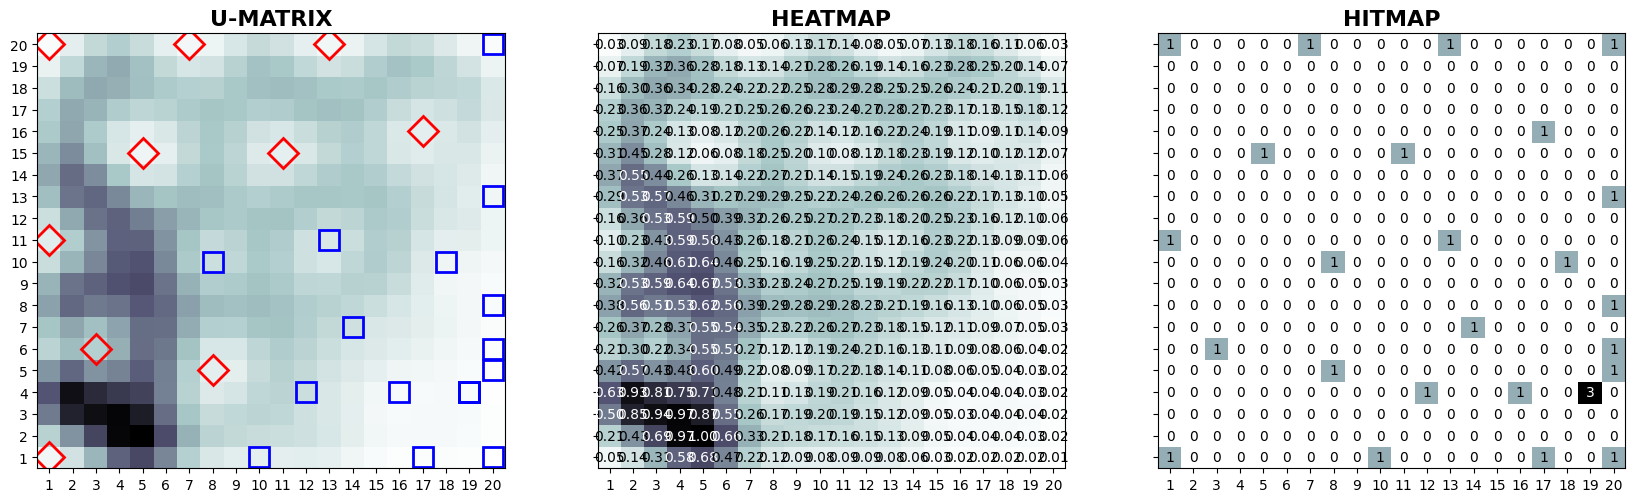

In [379]:
dpi = 100
width = np.round(1366 * 150 / 100)
height = 768*.75

fig, ax = plt.subplots(1, 3, figsize=(width/dpi, height/dpi), 
                       dpi=dpi, facecolor='w', sharex=True, sharey=True)
ax[0].pcolor(SOM.distance_map().T, cmap='bone_r')

markers = {'blue': 's', 'red': 'D'}

for i, d in enumerate(data):
    x, y = SOM.winner(d)
    ax[0].plot(x+0.5, y+0.5, markerfacecolor='None', markersize=15, 
               markeredgewidth=2, marker=markers[color_map[x][y]], 
               color=color_map[x][y])
ax[0].set_title('U-MATRIX', fontdict={'size': 16, 'fontweight': 'bold'})
ax[0].set_xticks(np.arange(ncol)+0.5)
ax[0].set_yticks(np.arange(nrow)+0.5)
ax[0].set_xticklabels(np.arange(ncol)+1)
ax[0].set_yticklabels(np.arange(nrow)+1)


dm = SOM.distance_map().T
ax[1].pcolor(dm, cmap='bone_r')
for i in range(dm.shape[0]):
    for j in range(dm.shape[1]):
        color = 'w' if dm[i][j] > dm.max()/2 else 'k'
        ax[1].text(j+0.5, i+0.5, '%.2f'%dm[i][j], ha='center', va='center', color=color)
ax[1].set_title('HEATMAP', fontdict={'size': 16, 'fontweight': 'bold'})
ax[1].set_xticks(np.arange(ncol)+0.5)
ax[1].set_yticks(np.arange(nrow)+0.5)
ax[1].set_xticklabels(np.arange(ncol)+1)
ax[1].set_yticklabels(np.arange(nrow)+1)


freq = SOM.activation_response(data).astype(int)
ax[2].pcolor(freq.T, cmap='bone_r') 
for (i, j), z in np.ndenumerate(freq.T):
    color = 'w' if z > freq.T.max()/2 else 'k'
    ax[2].text(j+0.5, i+0.5, z, ha='center', va='center', color=color)
# ax[1].colorbar(cmap)
ax[2].set_title('HITMAP', fontdict={'size': 16, 'fontweight': 'bold'})
ax[2].set_xticks(np.arange(ncol)+0.5)
ax[2].set_yticks(np.arange(nrow)+0.5)
ax[2].set_xticklabels(np.arange(ncol)+1)
ax[2].set_yticklabels(np.arange(nrow)+1)

plt.savefig(f"../metrics_uf_hourly.png",                                            
                transparent=False, bbox_inches='tight', pad_inches=0.1)